# DiSignAtlas

In [44]:
"""DiSignAtlas

This Notebook is used for exploring the DiSignAtlas dataset.

Strcuture:
    a. Disease Mapping
    b. Dataset Exploration
    c. DiSignAtlas get MeSH terms from Disease IDs
    
"""

'DiSignAtlas\n\nThis Notebook is used for exploring the DiSignAtlas dataset.\n\nStrcuture:\n    a. Disease Mapping\n'

## a. Disease Mapping

In [49]:
"""Disease Mapping
Here we are interested in Mapping the diseases to the corresponding MeSH terms.

Structure:
    1. Imports, Variables and Functions
    2. Load Data
    3. Disease Mapping
"""

# 1. Imports, Variables and Functions
# imports
import pandas as pd, numpy as np, os, sys, re, json, pickle, time, datetime, random
import requests
import xml.etree.ElementTree as ET
import logging
import json
from tqdm import tqdm
from bs4 import BeautifulSoup

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
# variables
data_path = os.path.join("..", "data", "DiSignAtlas", "dis_info_datasets")
mesh_file_path = "../data/MeSH/desc2023.xml"
output_path = os.path.join(
    "..", "results", "files", "DiSignAtlas", "disease_mapping.nlp.csv"
)
# functions


def retrieve_external_links(ids):
    base_url = "http://www.inbirg.com/disignatlas/detail/"
    results = {}

    for id in ids:
        url = f"{base_url}{id}"
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, "html.parser")
            print(response.content)
            external_links_section = soup.find("div", {"id": "external_links"})
            print(external_links_section)
            if external_links_section:
                links = external_links_section.find_all("a")
                results[id] = [
                    link.get("href")
                    for link in links
                    if "MeSH" in link.text or "DO" in link.text
                ]
            else:
                results[id] = "No external links section found"
        else:
            results[id] = "Failed to retrieve data"

    return results


# 2. Load Data
# load disease info
# Example usage with a list of IDs
example_ids = ["DSA00047"]
retrieve_external_links(example_ids)

# load disease mapping


# 3. Disease Mapping
# map diseases to MeSH terms

# Discarded because it takes too long to run ! ! !
# disease_mapping = list()

# for disease in tqdm(diseases):
#     best_match, best_score = find_best_fuzzy_match(disease, disease_mesh_terms)
#     disease_mapping.append([disease, best_match, best_score])


# Load the 'en_core_web_md' model

# Perform disease mapping


# save disease mapping

b'<!DOCTYPE html>\n<html lang="en">\n\t<head>\n\t\t<meta charset="UTF-8">\n\t\t<title>Detail</title>\n\t\t<!-- Bootstrap CSS -->\n<link rel="stylesheet" href="/diseasedb_static/cdn/css/bootstrap-4.3.1.min.css">\n<script src="/diseasedb_static/cdn/js/jquery-3.2.1.min.js"></script>\n<!-- <script type="text/javascript" charset="utf8" src="http://code.jquery.com/jquery-1.10.2.min.js"></script> -->\n<!--jquery1_test-->\n<!-- <script type="text/javascript" charset="utf8" src="http://code.jquery.com/jquery-1.10.2.min.js"></script> -->\n<script src="/diseasedb_static/cdn/js/popper-1.15.0.min.js"></script>\n<script src="/diseasedb_static/cdn/js/bootstrap-4.3.1.min.js"></script>\n<!-- bootstrap-select -->\n<link rel="stylesheet" href="/diseasedb_static/cdn/css/bootstrap-select-1.13.14.min.css">\n<!-- <script src="https://cdn.jsdelivr.net/npm/bootstrap-select@1.13.14/dist/js/i18n/defaults-*.min.js"></script> -->\n<!-- cytoscape -->\n<!-- <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.co

{'DSA00047': 'No external links section found'}

In [46]:
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 16.6 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


## b. Dataset Exploration


In [97]:
"""Dataset Exploration

The objective here is to retrieve information on the datasets. We are interested in answering the following questions:
    * How many datasets are there?
    * What types? 
    * What organisms?
    * How recent?
    * Is there overlap with iLINCS datasets?


Structure:
    1. Imports, Variables and Functions
    2. Load Data
    3. Dataset Exploration

"""

# 1. Imports, Variables and Functions
# imports
import numpy as np, pandas as pd, os, sys, re, json, pickle, time, datetime, random
import logging
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from collections import Counter
from bs4 import BeautifulSoup

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)

# variables
data_info_path = os.path.join("..", "data", "DiSignAtlas", "dis_info_datasets")


# functions


def get_date_from_geo(geo):
    """Get Date From GEO

    Function to retrieve date from GEO accesion code.

    Args:
        geo (str): GEO accession code.

    Returns:
        date (str): Date in fromat day month, year.
    """

    url = f"https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc={geo}"
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        submission_date = None
        for tr in soup.find_all("tr", bgcolor="#eeeeee"):
            tds = tr.find_all("td")
            if tds and len(tds) >= 2 and "Submission date" in tds[0].get_text():
                submission_date = tds[1].get_text().strip()
                break
        return submission_date
    else:
        return None


# 2. Load Data
df_data_info = pd.read_csv(data_info_path)

# * How many datasets are there?
logging.info(
    f"Nº of signatures: {df_data_info.shape[0]}\nNº of datasets: {df_data_info['accession'].nunique()}"
)

# 3. Dataset Exploration

2024-01-11 16:01:21,269 - INFO - Nº of signatures: 10306
Nº of datasets: 5059


In [135]:
df_data_info

,dsaid,accession,platform,deg_count,disease,diseaseid,tissue,data_source,library_strategy,organism,control_case_sample_count,definition,Unnamed: 12,Unnamed: 13,Unnamed: 14
0,DSA00001,GSE224398,GPL21103,1000,Alzheimer's Disease,C0002395,Hippocampus,GEO,scRNA-Seq,Mus musculus,1|1,DO:An Alzheimer's disease that has_material_ba...,NaN,NaN,NaN
1,DSA00002,GSE224398,GPL21103,1000,Alzheimer's Disease,C0002395,Hippocampus,GEO,scRNA-Seq,Mus musculus,1|1,DO:An Alzheimer's disease that has_material_ba...,NaN,NaN,NaN
2,DSA00003,GSE224398,GPL21103,1000,Alzheimer's Disease,C0002395,Hippocampus,GEO,scRNA-Seq,Mus musculus,1|1,DO:An Alzheimer's disease that has_material_ba...,NaN,NaN,NaN
3,DSA00004,GSE224022,GPL16791,1000,Retinoblastoma,C0035335,Retina,GEO,RNA-Seq,Homo sapiens,4|5,DO:A retinal cell cancer and malignant neoplas...,NaN,NaN,NaN
4,DSA00005,GSE126342,GPL11154,1000,Congenital Myotonic Dystrophy,C0410226,Skeletal muscle,GEO,RNA-Seq,Homo sapiens,9|11,MONDO:An inherited progressive disorder affect...,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10301,DSA10302,GSE6008,GPL96,1000,Ovarian Tumor,C1140680,Ovary,GEO,Microarray,Homo sapiens,4|41,DO:A female reproductive organ cancer that is ...,NaN,NaN,NaN
10302,DSA10303,GSE6280,GPL96,758,Kidney Tumor,C0022665,Kidney,GEO,Microarray,Homo sapiens,6|14,DO:A urinary system cancer that is located_in ...,NaN,NaN,NaN
10303,DSA10304,GSE6280,GPL97,337,Kidney Tumor,C0022665,Kidney,GEO,Microarray,Homo sapiens,6|14,DO:A urinary system cancer that is located_in ...,NaN,NaN,NaN
10304,DSA10305,GSE6344,GPL96,1000,Clear Cell Ependymoma,C1384403,Kidney,GEO,Microarray,Homo sapiens,5|5,"EFO:A WHO grade II, slow growing tumor of chil...",NaN,NaN,NaN


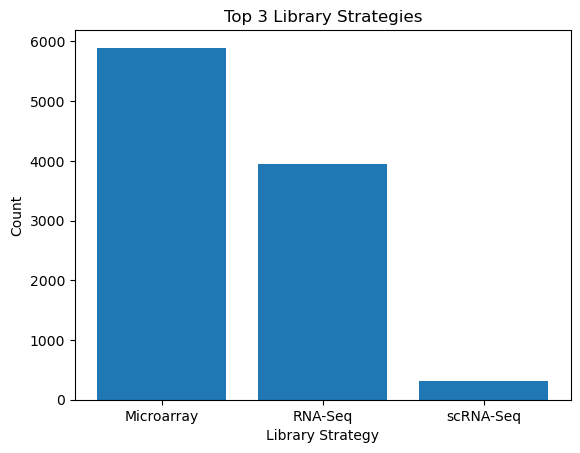

In [91]:
# * How many datasets are there?
# * What types?

data = dict(df_data_info["library_strategy"].value_counts()[:3])


# Extracting labels and values
labels = list(data.keys())
values = list(data.values())

# Creating the bar plot
plt.bar(labels, values)

# Adding titles and labels
plt.xlabel("Library Strategy")
plt.ylabel("Count")
plt.title("Top 3 Library Strategies")

# Show the plot
plt.show()

In [127]:
import random

# choose 100 random elements from the list
accessions = df_data_info["accession"].to_list()

subsample_accessions = random.sample(accessions, 100)

# * How recent?
years = list()
for accession in tqdm(subsample_accessions):
    try:
        date = get_date_from_geo(accession)
        years.append(int(date.split(", ")[1]))
    except:
        logging.info(f"Failed to retrieve date for {accession}")
        pass

100%|██████████| 100/100 [01:24<00:00,  1.19it/s]


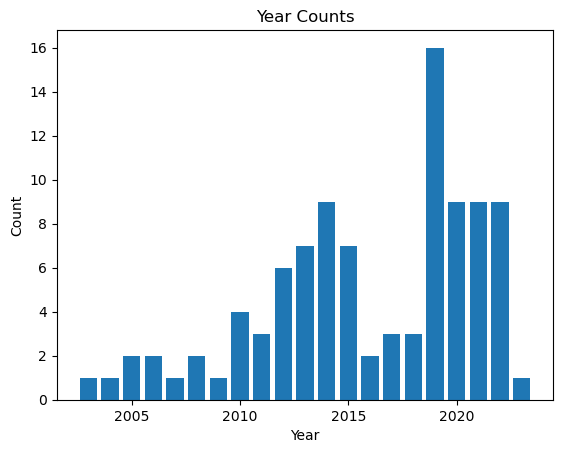

In [128]:
from collections import Counter

# Count the occurrences of each year
year_counts = Counter(years)

# Sort the years and get corresponding counts
sorted_years = sorted(year_counts.keys())
sorted_counts = [year_counts[year] for year in sorted_years]

# Create the bar plot
plt.bar(sorted_years, sorted_counts)

# Adding labels and title
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Year Counts")

# Show the plot
plt.show()

In [ ]:
# * Which is the overlap with iLINCS datasets?

In [131]:
from collections import Counter
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np, pandas as pd


def fetch_dataset_metadata(dataset_id):
    """Fetch dataset metadata/description for a given dataset."""
    endpoint = f"{base_url}/PublicDatasets/{dataset_id}"
    response = requests.get(endpoint)
    if response.status_code == 200:
        return response.json()  # assuming the response is in JSON format
    else:
        print("Error:", response.status_code, response.text)
        return None


def fetch_disease_signatures():
    """Fetch Disease Signatures"""

    # Construct the filtering JSON based on provided example
    # filter_json = {
    #     "where": {
    #         "factor": factor,
    #         #"baseline": baseline
    #     }
    # }
    # filter_str = json.dumps(filter_json)

    endpoint = f"{base_url}/SignatureMeta"
    # response = requests.get(endpoint, params={"filter": filter_str})
    response = requests.get(endpoint)
    if response.status_code == 200:
        return response.json()  # assuming the response is in JSON format
    else:
        print("Error:", response.status_code, response.text)
        return []

In [146]:
import multiprocessing
from tqdm import tqdm

filter_criteria = lambda s: (s["libraryid"] == "LIB_1")
base_url = "http://www.ilincs.org/api"

# Assuming fetch_disease_signatures and fetch_dataset_metadata are predefined functions
signatures = fetch_disease_signatures()
datasets = list(set([s["datasetid"] for s in signatures if filter_criteria(s)]))


def process_dataset(dataset_id):
    # retrieve metadata from iLINCS for specific datasetid
    metadata = fetch_dataset_metadata(dataset_id)
    gds_id = metadata["SourceID"]
    return gds_id


# Creating a pool of worker processes
pool = multiprocessing.Pool(multiprocessing.cpu_count())

# Map process_dataset over all datasets
results = list(tqdm(pool.imap(process_dataset, datasets), total=len(datasets)))

# Closing the pool and waiting for all processes to complete
pool.close()
pool.join()

# Assigning results to iLINCS_gds_ids
iLINCS_gds_ids = results

100%|██████████| 1087/1087 [00:24<00:00, 43.51it/s]


In [147]:
iLINCS_gds_ids

['GDS3417',
 'GDS3483',
 'GDS2791',
 'GDS2255',
 'GDS2219',
 'GDS2834',
 'GDS3759',
 'GDS738',
 'GDS2242',
 'GDS1258',
 'GDS2655',
 'GDS4100',
 'GDS1036',
 'GDS2240',
 'GDS961',
 'GDS2055',
 'GDS2310',
 'GDS4146',
 'GDS3471',
 'GDS2959',
 'GDS1023',
 'GDS2682',
 'GDS3042',
 'GDS4291',
 'GDS3128',
 'GDS2881',
 'GDS3342',
 'GDS1442',
 'GDS988',
 'GDS2084',
 'GDS2499',
 'GDS3034',
 'GDS3073',
 'GDS2341',
 'GDS4471',
 'GDS3864',
 'GDS806',
 'GDS3126',
 'GDS3499',
 'GDS1028',
 'GDS1210',
 'GDS3041',
 'GDS2429',
 'GDS3631',
 'GDS3758',
 'GDS968',
 'GDS881',
 'GDS2697',
 'GDS4159',
 'GDS4047',
 'GDS3463',
 'GDS2142',
 'GDS1886',
 'GDS4212',
 'GDS472',
 'GDS4133',
 'GDS3875',
 'GDS2970',
 'GDS2057',
 'GDS4358',
 'GDS2080',
 'GDS1064',
 'GDS2417',
 'GDS1436',
 'GDS534',
 'GDS1758',
 'GDS2656',
 'GDS3139',
 'GDS1498',
 'GDS1673',
 'GDS4232',
 'GDS2381',
 'GDS4279',
 'GDS3355',
 'GDS3383',
 'GDS4299',
 'GDS4051',
 'GDS1646',
 'GDS2931',
 'GDS261',
 'GDS2493',
 'GDS3964',
 'GDS1768',
 'GDS4360',
 

In [148]:
from Bio import Entrez

Entrez.email = "YourEmail@example.com"  # Always provide your email
handle = Entrez.esearch(db="gds", term=iLINCS_gds_ids[0])
record = Entrez.read(handle)

print(record)

{'Count': '26', 'RetMax': '20', 'RetStart': '0', 'IdList': ['200011971', '3417', '100000096', '300303212', '300303211', '300303210', '300303209', '300303208', '300303207', '300303206', '300303205', '300303204', '300303203', '300303202', '300303201', '300303200', '300303199', '300303198', '300303197', '300303196'], 'TranslationSet': [], 'TranslationStack': [{'Term': 'GDS3417[All Fields]', 'Field': 'All Fields', 'Count': '26', 'Explode': 'N'}, 'GROUP'], 'QueryTranslation': 'GDS3417[All Fields]'}


In [155]:
handle = Entrez.efetch(db="gds", term=record["IdList"][0], retmode="xml")
r = Entrez.read(handle)

print(r)

HTTPError: HTTP Error 400: Bad Request

In [134]:
from Bio import Entrez


def gds_to_geo(gds_id):
    Entrez.email = "YourEmail@example.com"  # Always provide your email
    handle = Entrez.esearch(db="gds", term=gds_id)
    record = Entrez.read(handle)
    geo_ids = record["IdList"]

    # Now you can fetch details for each GEO ID found
    for geo_id in geo_ids:
        handle = Entrez.efetch(db="gds", id=geo_id, retmode="xml")
        # Process the XML data as needed
        # ...

    return geo_ids  # or return processed information


# Example usage
gds_id = "GDSxxxx"  # Replace with your GDS ID
geo_ids = gds_to_geo(gds_id)
print(geo_ids)

GDS3820


In [138]:
[g for g in accessions if g.startswith("GDS")]

[]

## c. DiSignAtlas get MeSH terms from Disease IDs

In [41]:
"""DiSginAtlas DataSets

The objective here is to retrieve the datasets from DiSignAtlas.

Structure:
    1. Imports, Variables and Functions
    2. Load Data
    3. Retrieve DataSets
"""

# 1. Imports, Variables and Functions
# imports
import pandas as pd, numpy as np, os, sys, re, json, pickle, time, datetime, random
import requests
import xml.etree.ElementTree as ET
import time, re
from Bio import Entrez
import logging
import pandas as pd
import json
import logging
from multiprocessing import Pool


logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)

# variables
dataset_info_path = os.path.join("..", "data", "DiSignAtlas", "dis_info_datasets")
Entrez.email = "dylandaltonsub@gmail.com"


# functions
def query_disignatlas(disease_id):
    """Query DiSignAtlas for a given disease id
    Args:
        disease_id (str): The disease id to query
    Returns:
        response.text: The response text
    """
    url = f"http://www.inbirg.com/disignatlas/detail/{disease_id}"
    response = requests.get(url)

    if response.status_code != 200:
        print("Unable to retrieve data")

    return response.text


def extract_mesh_terms(js_function_str):
    """Extract the MeSH terms from the JavaScript function string
    Args:
        js_function_str (str): The JavaScript function string
    Returns:
        mesh_terms (list): The MeSH terms
    """
    # Find the start of the dbXrefs string
    start = js_function_str.find('dbXrefs = "') + len('dbXrefs = "')
    # Find the end of the dbXrefs string
    end = js_function_str.find('"', start)
    # Extract the dbXrefs string
    dbXrefs_str = js_function_str[start:end]
    # Split the string by the pipe character
    dbXrefs = dbXrefs_str.split("|")
    # Filter out and return only the MeSH terms
    mesh_terms = [x for x in dbXrefs if x.startswith("MeSH:")]
    return mesh_terms


def extract_do_terms(js_function_str):
    """Extract the Disease Ontology terms from the JavaScript function string
    Args:
        js_function_str (str): The JavaScript function string
    Returns:
        do_terms (list): The DO terms
    """
    # Find the start of the dbXrefs string
    start = js_function_str.find('dbXrefs = "') + len('dbXrefs = "')
    # Find the end of the dbXrefs string
    end = js_function_str.find('"', start)
    # Extract the dbXrefs string
    dbXrefs_str = js_function_str[start:end]
    # Split the string by the pipe character
    dbXrefs = dbXrefs_str.split("|")
    # Filter out and return only the MeSH terms
    do_terms = [x for x in dbXrefs if x.startswith("DO:")]
    return do_terms


def process_disease_id_mesh(disease_id):
    # Retrieve data
    data = query_disignatlas(disease_id)
    # Extract mesh terms
    mesh_terms = extract_mesh_terms(data)
    # Return a tuple of disease_id and mesh_terms
    return disease_id, mesh_terms


def process_disease_id_do(disease_id):
    # Retrieve data
    data = query_disignatlas(disease_id)
    # Extract mesh terms
    do_terms = extract_do_terms(data)
    # Return a tuple of disease_id and mesh_terms
    return disease_id, do_terms


# 2. Load Data
# retrieve disease ids
df_dataset_info = pd.read_csv(dataset_info_path)

# disease concept ids
disease_ids = df_dataset_info["dsaid"].unique().tolist()

# 3. Retrieve MeSH Terms
# retrieve do terms
with Pool() as pool:
    # Map the process_disease_id function to each disease_id
    # Use tqdm to show progress
    results = list(
        tqdm(pool.imap(process_disease_id_do, disease_ids), total=len(disease_ids))
    )
# Convert the results to dictionary
disease_id_2_do_id = dict(results)

 26%|██▌       | 2703/10306 [04:23<11:03, 11.45it/s]

Unable to retrieve data


100%|██████████| 10306/10306 [22:17<00:00,  7.70it/s]


In [44]:
len([k for k, v in disease_id_2_do_id.items() if (len(v) > 0) & (k in filtered_k)])

5943

In [ ]:
# retrieve MeSH id
# Create a pool of workers equal to the number of available CPU cores
with Pool() as pool:
    # Map the process_disease_id function to each disease_id
    # Use tqdm to show progress
    results = list(
        tqdm(pool.imap(process_disease_id_mesh, disease_ids), total=len(disease_ids))
    )

# Convert results to dictionary
disease_id_2_mesh_id = dict(results)

In [37]:
r = query_disignatlas("DSA00016")
extract_do_terms(r)

['DO:10534', 'DO:5517']

In [40]:
def parse_obo_file(file_path):
    with open(file_path, "r") as file:
        content = file.read()

    # Splitting the content into entries for each term
    terms = content.split("\n[Term]")
    mesh_terms = {}

    for term in terms:
        lines = term.split("\n")
        do_id = None
        mesh_id = None
        for line in lines:
            if line.startswith("id:"):
                do_id = line.split(": ")[1]
            if "xref: MESH:" in line:
                mesh_id = line.split("MESH:")[1].strip()
                if do_id and mesh_id:
                    if do_id in mesh_terms:
                        mesh_terms[do_id].append(mesh_id)
                    else:
                        mesh_terms[do_id] = [mesh_id]

    return mesh_terms


data_path = "../data/DiseaseOntology/doid.obo"  # Replace with your file path
do_to_mesh_terms = parse_obo_file(data_path)

# Example: print the MeSH terms for a specific DO term
print(do_to_mesh_terms.get("DOID:10534"))  # Replace with an actual DO term ID

['D013274']


In [31]:
filtered_k = df_dataset_info[df_dataset_info["organism"] == "Homo sapiens"][
    "dsaid"
].to_list()

In [33]:
len(filtered_k)

7140

In [32]:
len([k for k, v in disease_id_2_mesh_id.items() if (len(v) > 0) & (k in filtered_k)])

5700

In [6]:
disease_ids

'C0002395'

In [17]:
from bs4 import BeautifulSoup

url = f"http://www.inbirg.com/disignatlas/detail/DSA00001"
response = requests.get(url)

if response.status_code != 200:
    print("Unable to retrieve data")

response.text


mesh = extract_mesh_terms(response.text)

In [18]:
mesh

['MeSH:D000544']

## b. Compute Similarity Metrics

In [ ]:
"""Compute Similarity Metrics

iLINCS bechmarked several methods for "connecting" transcriptional signatures.
These include Extreme & Weighted correlations, Connectivity Score, Connectivity Map
and correlation based on Log Significance. 

Overall, all six methods performed very well in the bechmark. The decision was made
to use the Extreme Correlation of Signed Log P-values utilizing top 100 up- and down-
regulated genes as it showd best performance. 

Weighted Correlations are also used as they are almost as good but esasier to compute.

Here we implement iLINCS Extreme Correlations.

Structure:
    1. Imports, Variables, Functions
    2. Retrieve Data & Compute Extreme Signed Significance
    3. Compute Correlation of Extreme Signed Significance
    4. Benchmark Results
"""


# 1. Imports, Variables, Functions
# imports
import scipy.stats as stats, matplotlib.pyplot as plt, seaborn as sns, numpy as np, pandas as pd
import logging
import time, requests

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)


# variables


# functions


def compute_extreme_signed_significance(signed_significance, k=100):
    """
    Compute Extreme Signed Significance for top & bottom k ss genes, rest
    are assigned value of 0.

    Arguments:
    - signed_significance: list of tupples
        List of tupples [(geneid,ss), ...]
    - k: int()
        Top/Bottom k genes.

    Returns:
    - extreme_signed_significance: list of tupples
        List of gene ids and signed significance
    """
    # sort signed significance by value
    sorted_signed_significance = sorted(
        signed_significance, key=lambda x: x[1], reverse=True
    )

    # get top_bottom values
    top_bottom_genes = [ss[0] for ss in sorted_signed_significance[:k]] + [
        ss[0] for ss in sorted_signed_significance[-k:]
    ]

    # set values for non top/bottom k to 0
    extreme_signed_significance = {
        gene: ss if gene in top_bottom_genes else 0 for gene, ss in signed_significance
    }

    return extreme_signed_significance


# 2. Retrieve Data & Compute Extreme Signed Significance
# retrieve signatures

# 3. Compute Correlation of Extreme Signed Significance
# 4. Benchmark Results

### b.1 Define Signatures

In [58]:
def compute_signed_significance(dsaid):
    """
    Calculate signed significance for each gene in the signature.
    Args:
    - dsaid: str

    Returns:
    - signed_significance: list of tupples
    - d_signed_significance: list of tupples
    """
    data_path = os.path.join(
        "..", "data", "DiSignAtlas", "dsa_diff_download", f"{dsaid}_alldiff.txt"
    )

    df = pd.read_csv(data_path, sep="\t")

    signed_significance = list()
    de_values = list()
    for index, row in df.iterrows():
        sign = np.sign(row["Log2FC"])
        ss = sign * (-np.log10(row["AdjPValue"]))
        signed_significance.append((row["GeneID"], ss))
        de_values.append((row["GeneID"], row["Log2FC"]))

    return signed_significance, de_values


signed_significance, de_values = compute_signed_significance("DSA00009")

In [60]:
[a for a in signed_significance if a[1] < 0]

[(100506164, -1.0482903428928962e-05),
 (643707, -7.216032825769299e-05),
 (9113, -7.216032825769299e-05),
 (9686, -7.216032825769299e-05),
 (83604, -7.216032825769299e-05),
 (90333, -7.216032825769299e-05),
 (254170, -7.216032825769299e-05),
 (51527, -7.216032825769299e-05),
 (7781, -0.00011740666130554824),
 (9399, -7.216032825769299e-05),
 (81570, -7.216032825769299e-05),
 (2224, -7.216032825769299e-05),
 (201456, -7.216032825769299e-05),
 (64843, -7.216032825769299e-05),
 (80013, -0.00016275978900462097),
 (81856, -0.0001419452003265787),
 (51750, -0.00016275978900462097),
 (5319, -7.216032825769299e-05),
 (9909, -0.00016275978900462097),
 (5672, -0.00016275978900462097),
 (55805, -7.216032825769299e-05),
 (23036, -0.00016275978900462097),
 (55206, -0.00018375680103130155),
 (3106, -0.0003448627441005334),
 (79755, -0.00016275978900462097),
 (10660, -7.216032825769299e-05),
 (128368, -0.0001419452003265787),
 (171483, -0.00024146782997664767),
 (201254, -0.0003448627441005334),
 (9

In [54]:
ls ../data/DiSignAtlas/dsa_diff_download

DSA00001_whole_diff_regulation.csv  DSA05154_alldiff.txt
DSA00002_whole_diff_regulation.csv  DSA05155_alldiff.txt
DSA00003_whole_diff_regulation.csv  DSA05156_alldiff.txt
DSA00004_alldiff.txt                DSA05157_alldiff.txt
DSA00005_alldiff.txt                DSA05158_alldiff.txt
DSA00006_alldiff.txt                DSA05159_alldiff.txt
DSA00007_alldiff.txt                DSA05160_alldiff.txt
DSA00008_alldiff.txt                DSA05161_alldiff.txt
DSA00009_alldiff.txt                DSA05162_alldiff.txt
DSA00010_alldiff.txt                DSA05163_alldiff.txt
DSA00011_alldiff.txt                DSA05164_alldiff.txt
DSA00012_alldiff.txt                DSA05165_alldiff.txt
DSA00013_alldiff.txt                DSA05166_alldiff.txt
DSA00014_alldiff.txt                DSA05167_whole_diff_regulation.csv
DSA00015_alldiff.txt                DSA05168_alldiff.txt
DSA00016_alldiff.txt                DSA05169_alldiff.txt
DSA00017_whole_diff_regulation.csv  DSA05170_alldiff.txt
DSA00018_alldiff.

In [48]:
list(zip(df["AdjPValue"], df["GeneID"]))

[(3.03040022797578e-12, 6346),
 (7.229378755833691e-20, 10563),
 (5.36173113263678e-24, 100288175),
 (3.96279691535782e-22, 161342),
 (1.75953839315723e-05, 3514),
 (3.28662229873021e-06, 5764),
 (3.03413072177626e-14, 100506498),
 (1.74750277277323e-06, 6696),
 (3.76426911362915e-08, 1081),
 (4.13380886306018e-05, 50486),
 (2.4096142213649e-05, 3002),
 (8.96362663267016e-09, 3552),
 (1.24769361430009e-16, 79413),
 (6.58331309780413e-05, 388372),
 (2.9616977304239e-08, 6846),
 (2.46928526679151e-39, 3604),
 (1.10534631225217e-07, 857),
 (0.00109167175892, 1410),
 (1.29553335516571e-10, 107986884),
 (5.14789245125153e-06, 4332),
 (2.66451492328556e-11, 58475),
 (2.41717481235235e-05, 6349),
 (2.3374054187847003e-10, 9077),
 (0.0009931879178145, 6947),
 (0.0237449730354693, 115908),
 (5.59732394766066e-07, 3310),
 (2.134097684782e-24, 104384744),
 (1.8449403991296897e-11, 64231),
 (nan, 28602),
 (6.50730975027828e-32, 7850),
 (0.0001811180796416, 284422),
 (7.58102104724266e-09, 9173),
 

### b.2 Benchmark Signatures